In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

from backdoor.attacks import BadNets
from backdoor.poisons import BadNetsPoison

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = '/data/'

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
])

In [4]:
train_set = datasets.CIFAR10(
    root=data_dir, train=True, download=False, transform=transform_train
)
test_set = datasets.CIFAR10(
    root=data_dir, train=False, download=False, transform=transform_test
)

poisoned_testset = BadNetsPoison(
    dataset=test_set,
    target_class=5,
    poison_ratio=1,
    poison_type='dirty',
    trigger_img='trigger_10',
    trigger_size=3
)

trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    test_set, batch_size=128, shuffle=False, num_workers=2
)

poisoned_testloader = torch.utils.data.DataLoader(
    poisoned_testset, batch_size=128, shuffle=False, num_workers=2
)

In [5]:
net = models.resnet18(weights=None, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [6]:
badnets_attack = BadNets(
    device=device,
    classifier=net,
    trainset=train_set,
    testset=test_set,
    target_class=5,
    epochs=50,
    batch_size=128,
    optimizer=optimizer,
    loss_function=loss_fn
)

INFO - Attack: BadNets
INFO - Classifier: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [7]:
# badnets_attack.attack(
#     poison_ratio=0.1,
#     poison_type='dirty',
#     trigger_img='trigger_10',
#     trigger_size=3
# )

# torch.save(net.state_dict(), 'cifar10_badnet_50.pth')

In [8]:
poisoned_net = models.resnet18(weights=None, num_classes=10)
poisoned_net.load_state_dict(torch.load('cifar10_badnet_50.pth'))
loaded_net = poisoned_net.to(device)

In [9]:
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def evaluate_attack(model, clean_loader, poisoned_loader, target_label):

    clean_acc = test_model(model, clean_loader)
    attack_success_count = 0

    for inputs, labels, targets in poisoned_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == targets).sum().item()
        attack_success_count += correct

    attack_success_rate = attack_success_count / len(poisoned_loader.dataset)
    return clean_acc, attack_success_rate


acc, asr = evaluate_attack(poisoned_net, testloader, poisoned_testloader, target_label=5)
print(f'Clean accuracy: {acc:.4f}, \nAttack success rate: {asr:.4f}')

Clean accuracy: 0.8330, 
Attack success rate: 0.9937


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_cifar10_images(image1, image2, label1, label2, target, model):

    # Transform the images and move to device
    image1_tensor = image1.unsqueeze(0).to(device)
    image2_tensor = image2.unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        pred1 = model(image1_tensor).argmax(dim=1).item()
        pred2 = model(image2_tensor).argmax(dim=1).item()


    # Convert the images from tensors to numpy arrays for visualization
    image1 = image1_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
    image2 = image2_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

    # denormalize
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image1 = std * image1 + mean
    image2 = std * image2 + mean
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the first image (clean image)
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title(f'Clean Image\nLabel: {label1}\nPrediction: {pred1}')

    # Display the second image (poisoned image)
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title(f'Poisoned Image\nLabel: {label2}, Target: {target}\nPrediction: {pred2}')

    # Show the plot
    plt.show()


In [11]:
img, label = test_set[3]
poisoned_img, poisoned_label, target = poisoned_testset[3]

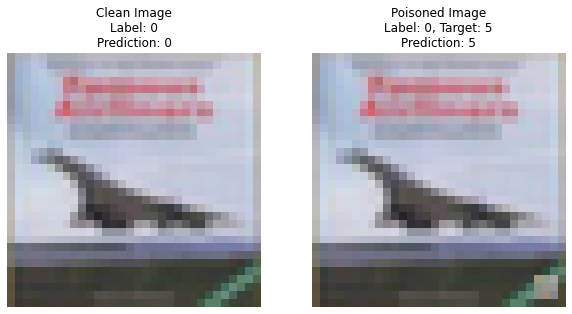

In [12]:
visualize_cifar10_images(img, poisoned_img, label, poisoned_label, target, poisoned_net)

# Fine Pruning Defense


In [13]:
from backdoor.defenses import FinePrune

In [14]:
new_net = models.resnet18(weights=None, num_classes=10)
new_net.load_state_dict(torch.load('cifar10_badnet_50.pth'))
new_optimizer = optim.Adam(new_net.parameters(), lr=1e-3)

fineprune_defense = FinePrune(
    new_net,
    testloader,
    testloader,
    loss_fn,
    new_optimizer,
    device
)

In [15]:
fineprune_defense.fine_prune(num_epochs=10, prune_ratio=0.05, min_val_acc=0.5)

/home/sn3006/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1, Loss: 0.5792, Accuracy: 0.89
Epoch: 2, Loss: 0.3598, Accuracy: 0.93
Epoch: 3, Loss: 0.2573, Accuracy: 0.95
Epoch: 4, Loss: 0.2388, Accuracy: 0.94
Epoch: 5, Loss: 0.2920, Accuracy: 0.94
Epoch: 6, Loss: 0.2696, Accuracy: 0.95
Epoch: 7, Loss: 0.2624, Accuracy: 0.93
Epoch: 8, Loss: 0.2832, Accuracy: 0.95
Epoch: 9, Loss: 0.2765, Accuracy: 0.95
Epoch: 10, Loss: 0.2699, Accuracy: 0.93


In [16]:
defended_net = fineprune_defense.model
evaluate_attack(defended_net, testloader, poisoned_testloader, target_label=5)

(0.9339, 0.1286)

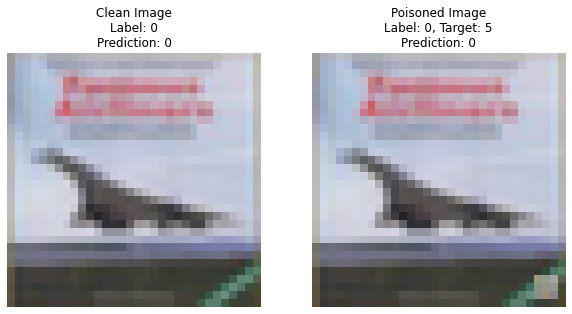

In [17]:
visualize_cifar10_images(img, poisoned_img, label, poisoned_label, target, defended_net)

In [17]:
torch.save(defended_net.state_dict(), 'cifar10_badnet_50_repaired.pth')